# Imports and type definitions

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from cycler import cycler

palette = ['#ff0000', '#653700', '#a3cc00', '#06c2ac', '#0088ff', '#db5fff', 
           '#eb3596', '#ef8686', '#ff8800', '#5e664d', '#269991', '#1d3f73', 
           '#7e468c', '#d96236', '#7f2200']

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIG_SIZE = 18
HUGE_SIZE = 20

plt.style.use('bmh')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)       # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=HUGE_SIZE)    # fontsize of the figure title
plt.rc('figure', figsize=(8,6))          # figure size
plt.rc('lines', linewidth=3)             # controls line width
plt.rc('axes', prop_cycle=cycler('color', palette))

In [3]:
%env JAX_ENABLE_X64=1
%env JAX_PLATFORM_NAME=cpu

env: JAX_ENABLE_X64=1
env: JAX_PLATFORM_NAME=cpu


In [4]:
import jax
import jax.numpy as jnp

DeviceArray = jnp.DeviceArray # type alias

In [5]:
import re
import os
import pickle
from typing import List
from functools import reduce

# Constants (as used in the experiment)

For the details refer to the ``settings.txt`` file inside the experiment dir.

In [6]:
# model size (MPS_SIZE * LOCAL_DIM + BOND_DIM = TRAIN_SIZE)
MPS_SIZE = 4
LOCAL_DIM = 4
BOND_DIM = 8

# APPROX RANK
APPROX_RANK = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30]

# NOISE MODEL
PERCENT_NOISE = [0.1, 0.25, 0.5]

# SAVE/PRINT after that many epochs
SAVE_AFTER_EPOCHS = 100

# Weight initialisation
WEIGHT_INIT = 'he-uniform'

# Helpers

In [7]:
from collections import defaultdict

def idict():
    """Infinitely nested dict"""
    return defaultdict(idict)

def idict2dict(dic):
    """Infinitely nested dict to plain dict"""
    if isinstance(dic, defaultdict):
        dic = {k: idict2dict(v) for k, v in dic.items()}
    return dic

In [8]:
def merge(a, b, path=None):
    "Merges b into a"
    if path is None: path = []
    for key in b:
        if key in a:
            if isinstance(a[key], dict) and isinstance(b[key], dict):
                merge(a[key], b[key], path + [str(key)])
            elif a[key] == b[key]:
                pass # same leaf value
            else:
                raise Exception('Conflict at %s' % '.'.join(path + [str(key)]))
        else:
            a[key] = b[key]
    return a

# Print data for a single experiment

In [9]:
parent_dir = './experiment'

The figure directory is stored seperately

In [10]:
fig_dir = os.path.join(parent_dir, 'figs')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [11]:
experiment_date = '20220405'

In [12]:
experiment = f'{experiment_date}-noise-0.1-{WEIGHT_INIT}'  # the particular directory

In [13]:
lrn_dir = os.path.join(parent_dir, experiment, 'learning')
res_dir = os.path.join(parent_dir, experiment, 'results')

In [14]:
import re

losses = []
for approx_rank in APPROX_RANK:
    dir_path = os.path.join(res_dir, f'approx_rank_{approx_rank}')
    file_path = os.path.join(dir_path, 'loss.pkl')
    with open(file_path, 'rb') as f:
        losses.append(pickle.load(f))
    
results = reduce(merge, losses)

# Plotting

In [15]:
def plot_epochs_curve(results, title, fig_file=None):
    # converting into a dict
    results = idict2dict(results)
    for smpl_size, res in results.items():
        data = [r.item() for r in res]
        plt.plot(data, label=f'Rank-{smpl_size}', linewidth=3)
    plt.grid(True)
    # plt.yscale('log')
    xticks_values = [int(l) for l in plt.gca().get_xticks()]
    # plt.axes().xaxis.set_major_locator(mticker.FixedLocator(xticks_values))
    plt.gca().set_xticklabels(xticks_values)
    # plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0)) 
    # plt.gca().xaxis.set_major_formatter(
    #     plt.matplotlib.ticker.StrMethodFormatter("{x:.0f}00")
    # )
    # Hide first 0 in xticks
    # xticks = plt.gca().xaxis.get_major_ticks()
    # xticks[0].label1.set_visible(False)
    plt.title(title)
    plt.legend(loc='upper right', fontsize=12)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=14)
    if fig_file:
        plt.savefig(fig_file)

<ipython-input-15-f03c46fda495>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xticks_values)


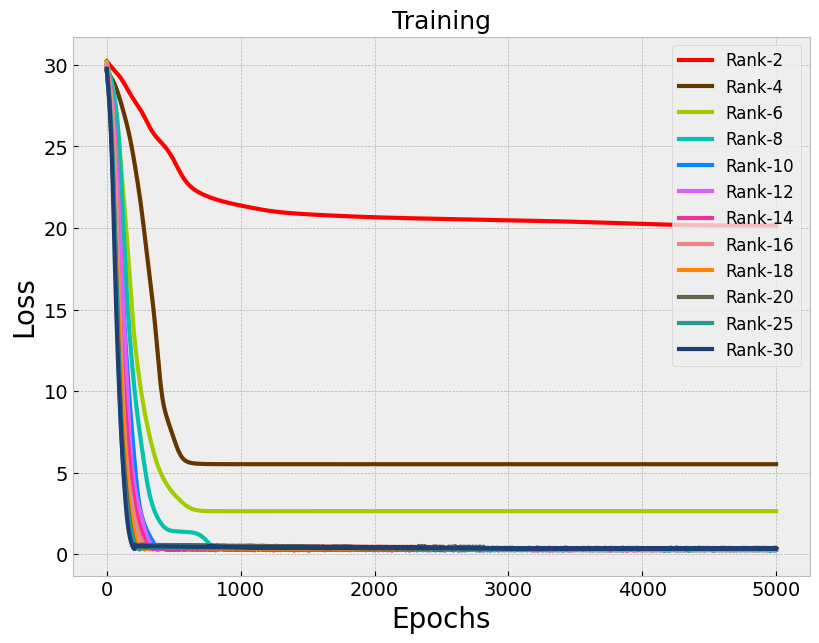

In [16]:
plt.rcParams["figure.figsize"] = (9.5,7)
plot_epochs_curve(results['train'], 
                  title='Training',
                  fig_file=os.path.join(fig_dir, f'{experiment}-learning-curve-training.png')
                  )

<ipython-input-15-f03c46fda495>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xticks_values)


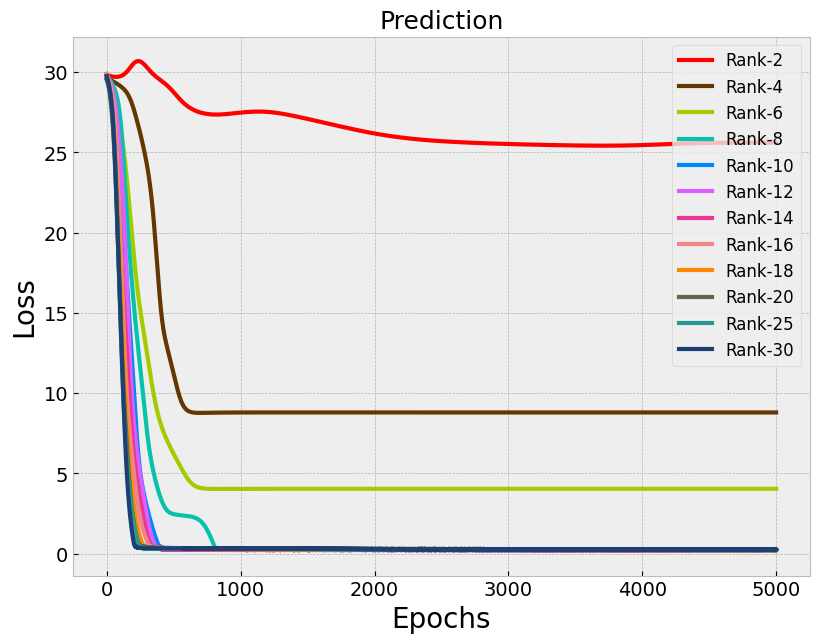

In [17]:
plt.rcParams["figure.figsize"] = (9.5,7)
plot_epochs_curve(results['test'], 
                  title='Prediction',
                  fig_file=os.path.join(fig_dir, f'{experiment}-learning-curve-prediction.png'))


In [18]:
def plot_approx_rank_curve(results, title, fig_file=None):
    # converting into a dict
    results = idict2dict(results)
    data = {k:jnp.mean(jnp.asarray(vs[-100:])).item() 
            for k,vs in results.items()}
    x, y = zip(*data.items())
    plt.plot(x, y, color='blue', linewidth=3)
    plt.yscale('log')
    plt.grid(True)
    plt.xticks(range(0, APPROX_RANK[-1]+1, 4))
    #plt.xlim(2,30)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('Approximation Rank', fontsize=20)
    plt.ylabel('Loss (log-scale)', fontsize=20)
    plt.title(title, fontsize=24)
    plt.legend(['Loss'], loc='upper right', fontsize=14)
    if fig_file:
        plt.savefig(fig_file)

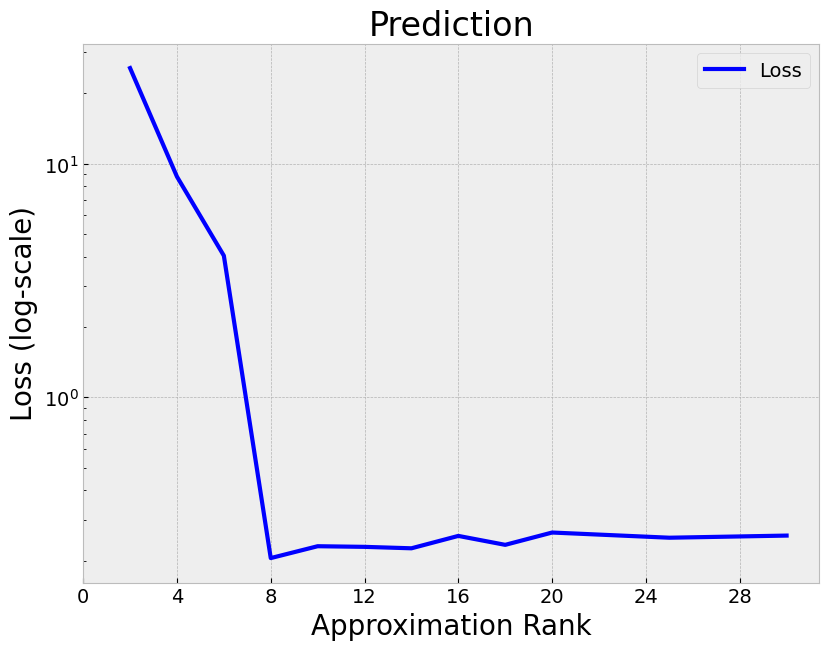

In [19]:
plt.rcParams["figure.figsize"] = (9.5,7)
plot_approx_rank_curve(results['test'], 
                       title='Prediction',
                       fig_file=os.path.join(fig_dir, f'{experiment}-logloss-vs-rank-prediction.png'))

# Calculating the environment spectrum

In [20]:
def dot(mps1: List[DeviceArray], mps2: List[DeviceArray]) -> jnp.double:
    """
    Dot product of an MPS with another mps.
    --A1----A2--...--An-- (MPS1)
      |     |        |
    
      |     |        |
    --B1----B2--...--Bn-- (MPS2)
    """
    # contracts individual components
    cdot = lambda x, y: jnp.einsum('pqr,uqv->purv', x, y)
    # multiply two neighbouring tensors
    mult = lambda x, y: jnp.einsum('purv,rvts->puts', x, y)
    # contract all
    res = reduce(mult, jax.tree_multimap(cdot, mps1, mps2))
    return res.squeeze()

def mps_norm(mps: List[DeviceArray]) -> jnp.double:
    """Computing the squared norm of an MPS"""
    mps_conj = jax.tree_map(jnp.conj, mps)
    return dot(mps, mps_conj)

In [21]:
def e_spec_env(params, i=0):
    """Compute the entanglement spectrum of each tensor with the environment."""
    # The idea is to use MPS and MPS* and connect all the physical legs except one (indexed by i).
    # The construction results in a matrix of dimension d x d where d is physical dimension.
    # The result descibes the spectrum of the entanglement of that tensor with the whole environment.
    assert isinstance(params, list), 'Expecting a list type'
    assert 0 <= i <= len(params)-1,  'Bad index => must be 0 <= i <= len(params)-1'
    
    if len(params) == 1:
        mat = jnp.einsum('par,pbr->ab', p, p.conj())
    
    if i == 0:
        right = mps_norm(params[1:])
        if right.ndim == 0:
            right = right * jnp.eye(2)
        mat = jnp.einsum('par,ubv,rv->paub', params[0], params[0].conj(), right)
    elif i == len(params) - 1:
        left = mps_norm(params[:-1])
        if left.ndim == 0:
            left = left * jnp.eye(2)
        mat = jnp.einsum('pu,par,ubv->ravb', left, params[-1], params[-1].conj())
    else: 
        left = mps_norm(params[:i])
        if left.ndim == 0:
            left = left * jnp.eye(2)
        
        right = mps_norm(params[i+1:])
        if right.ndim == 0:
            right = right * jnp.eye(2)  

        mat = jnp.einsum('pu,par,ubv,rv->ab', left, params[i], params[i].conj(), right)

    mat = mat.squeeze()
    _, s, _ = jnp.linalg.svd(mat)
    
    return s

def e_entropy(params, i=0):
    """Compute the entanglement entropy of a bipartition between sites i and i+1."""

    assert isinstance(params, list), 'Expecting a list type'
    assert 1 <= i <= len(params)-1,  'Bad index => must be 1 <= i <= len(params) - 1'
    
    if len(params) == 1:
        raise ValueError('The MPS has one site only')
    
    left = mps_norm(params[:i])
    if left.ndim == 0:
        left = left * jnp.eye(2)

    right = mps_norm(params[i:])
    if right.ndim == 0:
        right = right * jnp.eye(2)
    
    # full density matrix
    rho = jnp.einsum('pq,uv->pquv', left, right)
    # reduced density matrix
    rho_a = jnp.einsum('piui->pu', rho)
    
    _, s, _ = jnp.linalg.svd(rho_a)
    entropy = -jnp.sum(s*jnp.log(s))
    
    return entropy

# Loading parameters

In [22]:
params_dir = os.path.join(lrn_dir, 'approx_rank')

env_spectrum = idict()
ent_entropy = idict()
for approx_rank in APPROX_RANK:
    dir_path = os.path.join(f'{params_dir}_{approx_rank}')
    files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) 
             if os.path.isfile(os.path.join(dir_path, f))]
    # sort by step to make the ordering correct
    files.sort(key=lambda f: int(re.sub('\D', '', f)))
    for step, params_file in enumerate(files):
        with open(params_file, 'rb') as f:
            params = pickle.load(f)
        # entanglement spectrum environment
        es = [e_spec_env(params,i) for i in range(MPS_SIZE)]
        env_spectrum[approx_rank][step] = es
        # entanglement entropy bipartitions
        ee = [e_entropy(params, i) for i in range(1,MPS_SIZE)]
        ent_entropy[approx_rank][step] = ee

In [23]:
env_spectrum = idict2dict(env_spectrum)
ent_entropy = idict2dict(ent_entropy)

In [24]:
def plot_entanglement_env_spectrum(data, title, fig_file=None):
    """Plot entanglement with the environment"""
    t, s, _ = data.shape

    cols = t//2

    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.suptitle(title, fontsize=24)
    plt.subplots_adjust(hspace = 0.15, wspace=0.1)
    for i in range(t):
        pid = (i//cols, i%cols) # plot id
        for j in range(s):
            axs[pid].plot(data[i,j,:], linewidth=3, label=r'$\lambda_{}$'.format(j+1))
            axs[pid].set_title(f'Tensor {i+1}', fontsize=16)
            axs[pid].grid(True)
            axs[pid].legend(loc='upper right', fontsize=12)
            axs[pid].tick_params(axis='both', which='major', labelsize=12)
            axs[pid].tick_params(axis='both', which='minor', labelsize=10)
            axs[pid].ticklabel_format(axis='y', style='sci', scilimits=(4,4))
            
    for ax in axs.flat:
        ax.set_xlabel(xlabel='Epochs', fontsize=16)
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].label1.set_visible(False)

    for ax in axs.flat:
        ax.label_outer()
    
    xticks_values = [int(l*SAVE_AFTER_EPOCHS) for l in plt.gca().get_xticks()]
    plt.gca().set_xticklabels(xticks_values)
    # plt.gca().xaxis.set_major_formatter(
    #     plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}00')
    # )
    # # Hide first 0 in xticks
    # xticks = plt.gca().xaxis.get_major_ticks()
    # xticks[0].label1.set_visible(False)

    if fig_file:
        plt.savefig(fig_file)

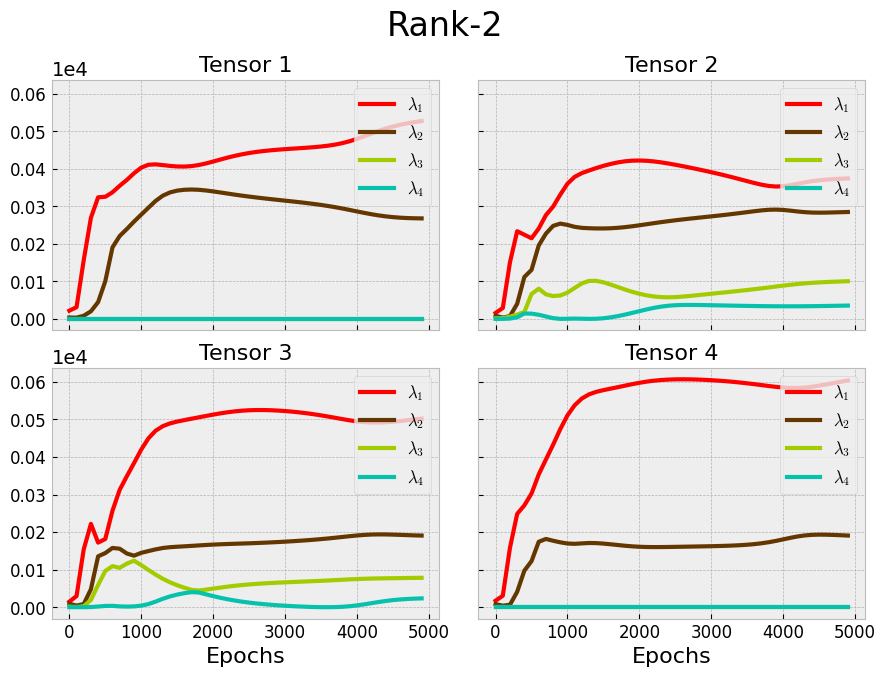

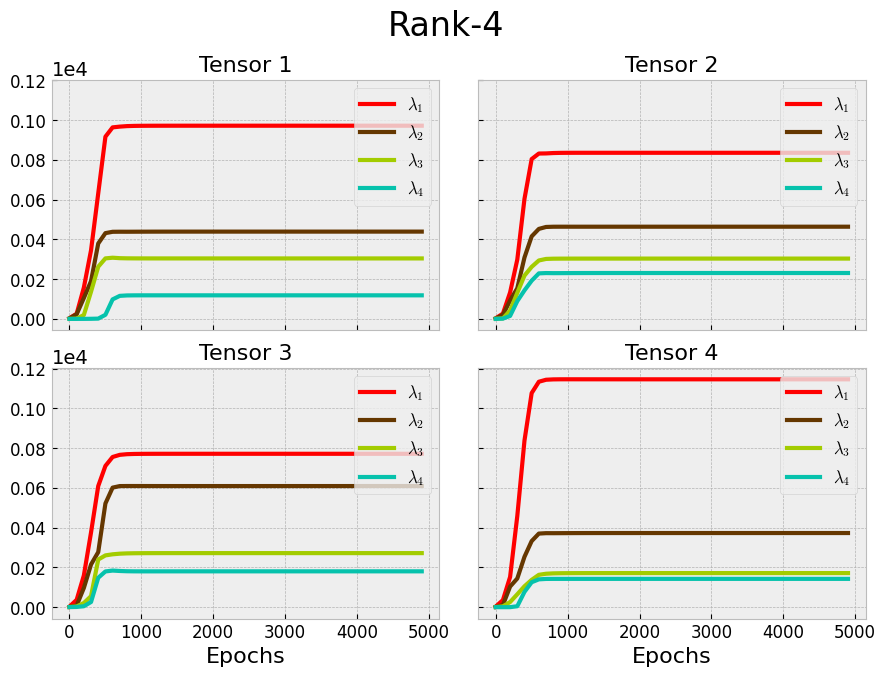

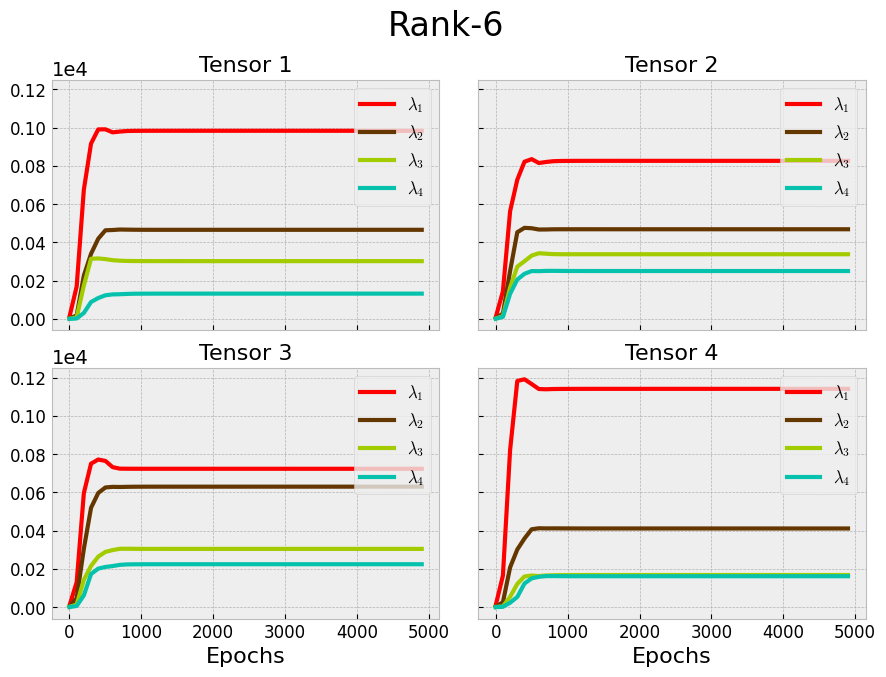

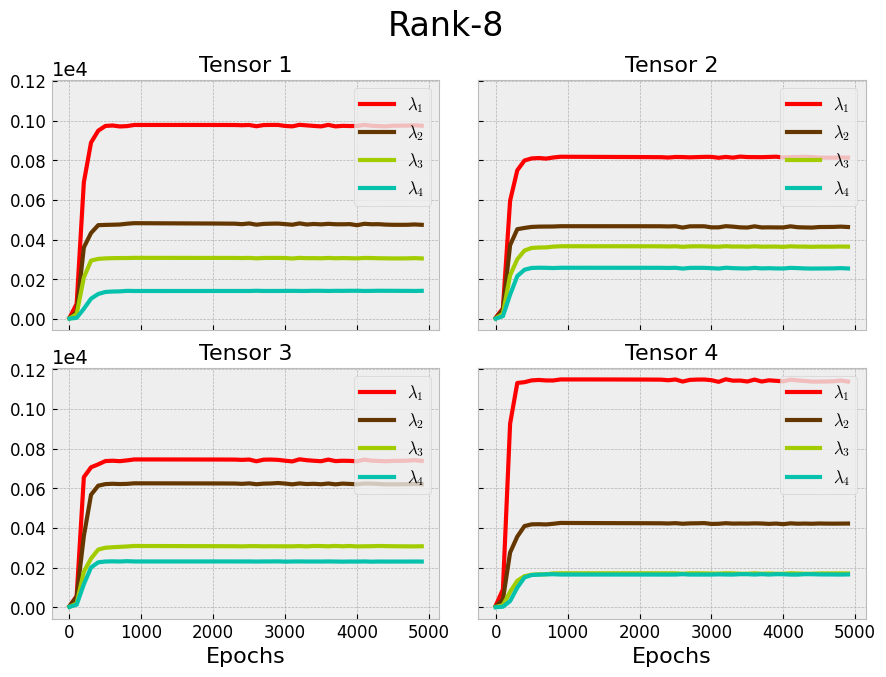

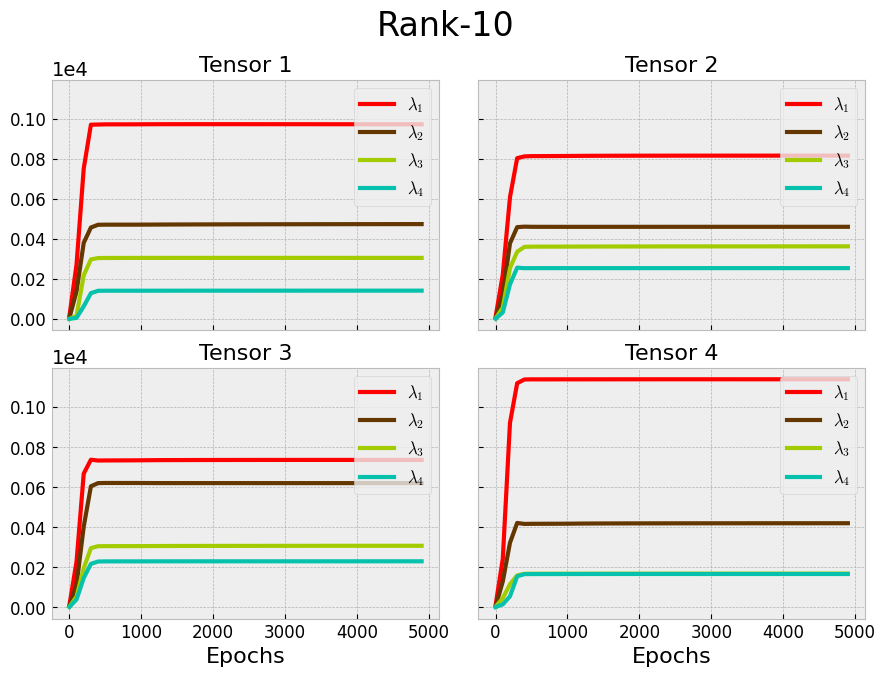

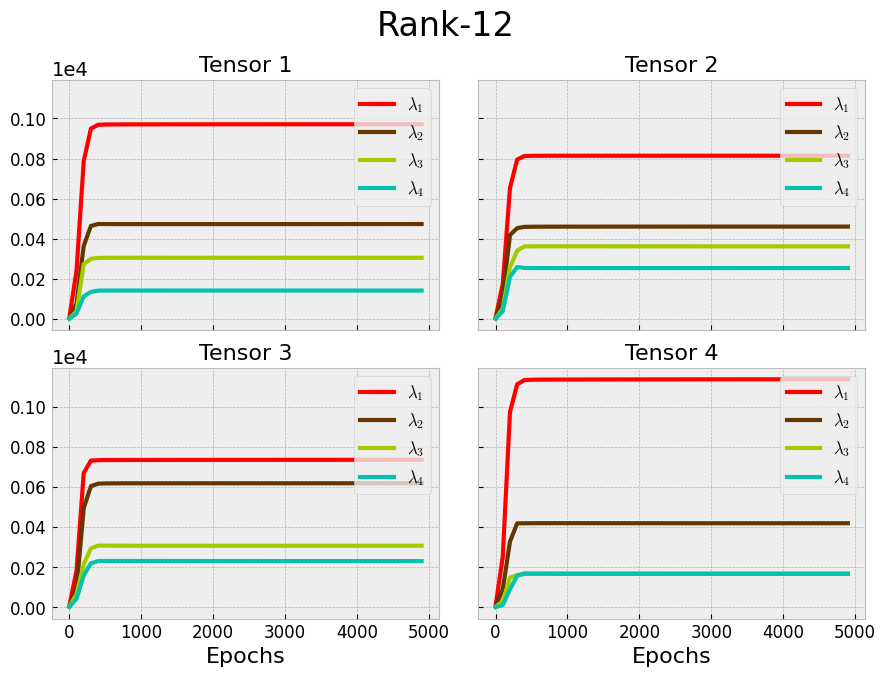

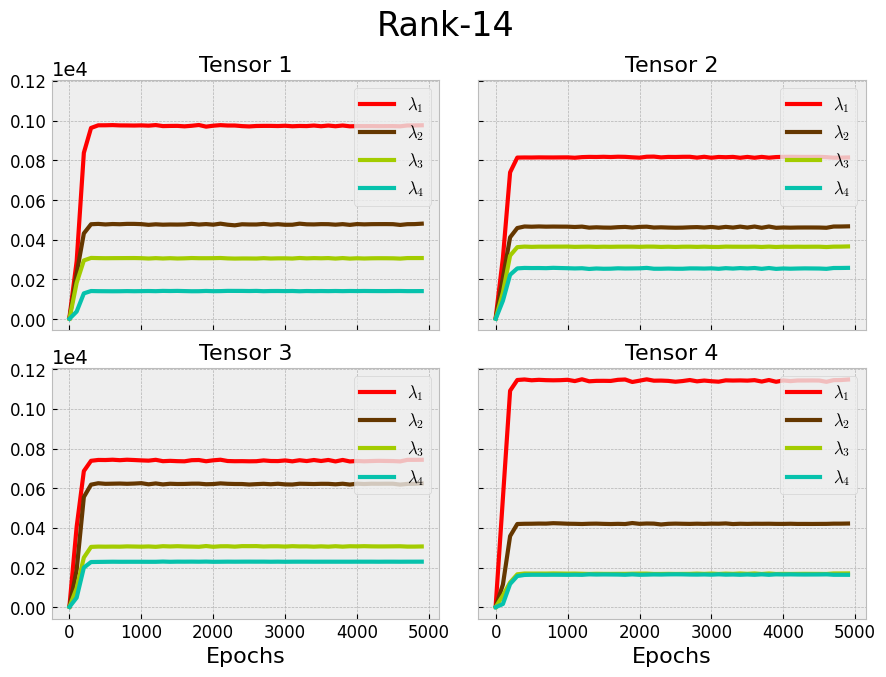

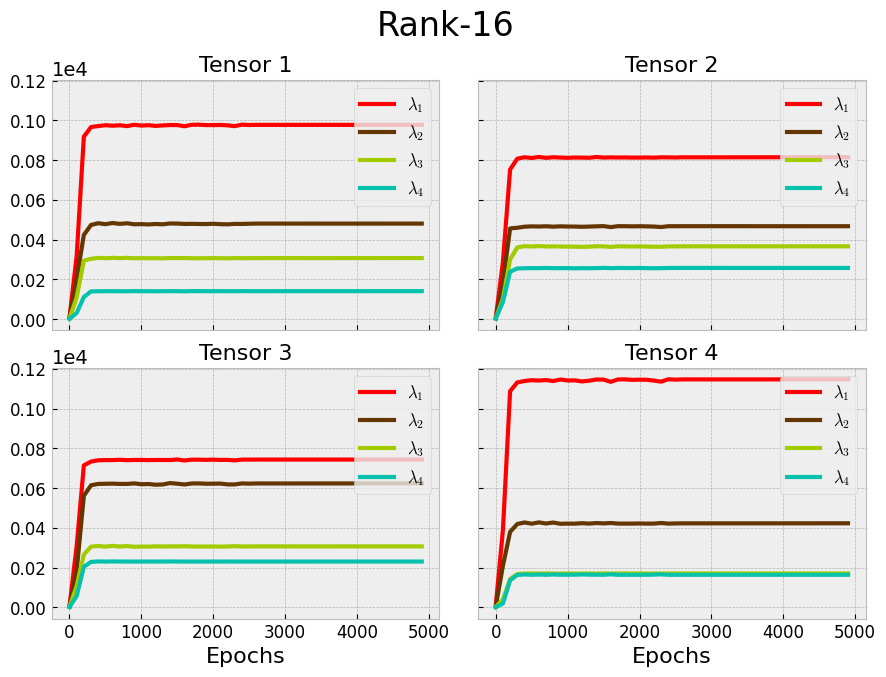

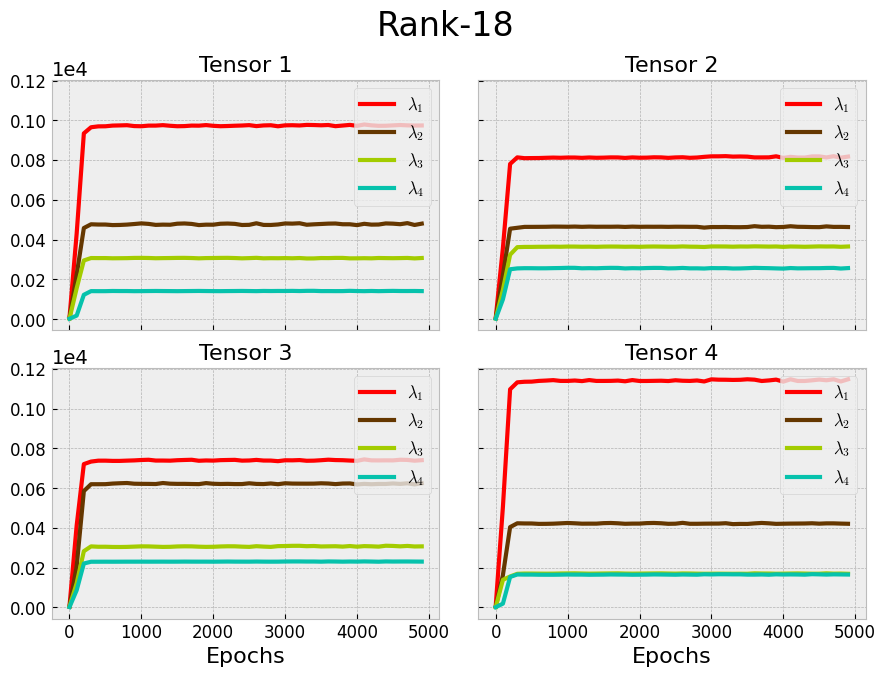

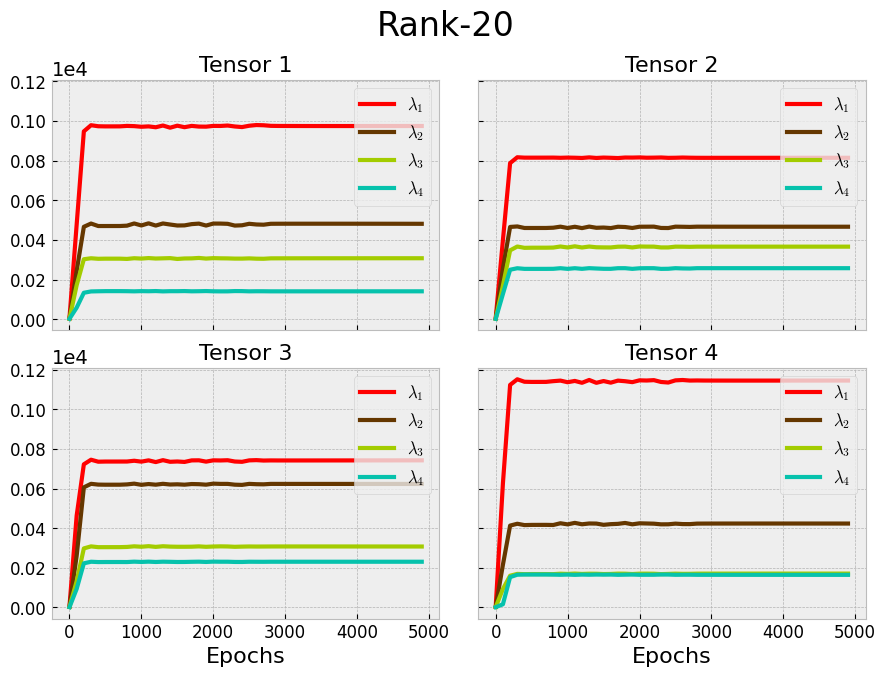

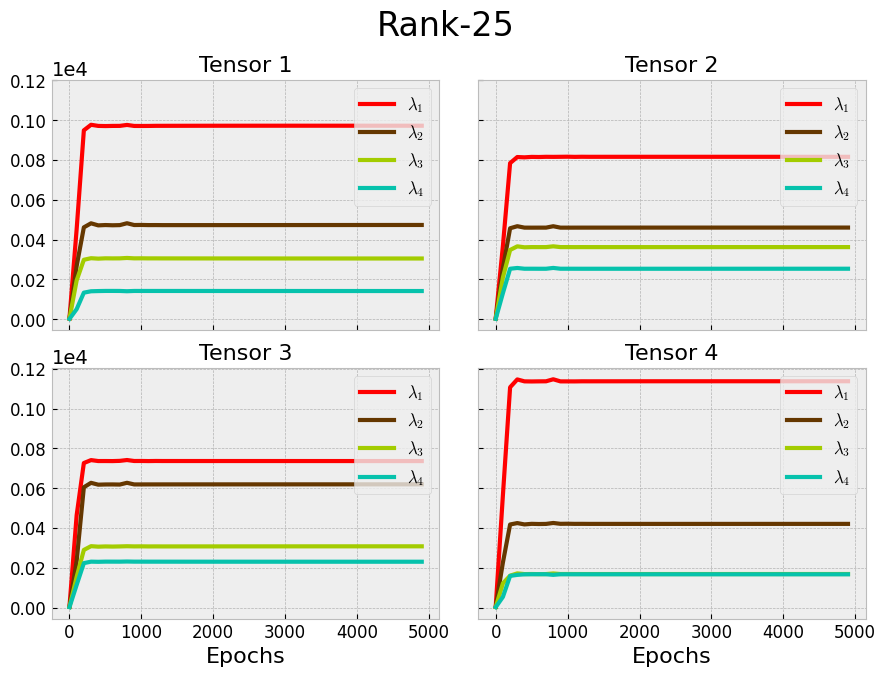

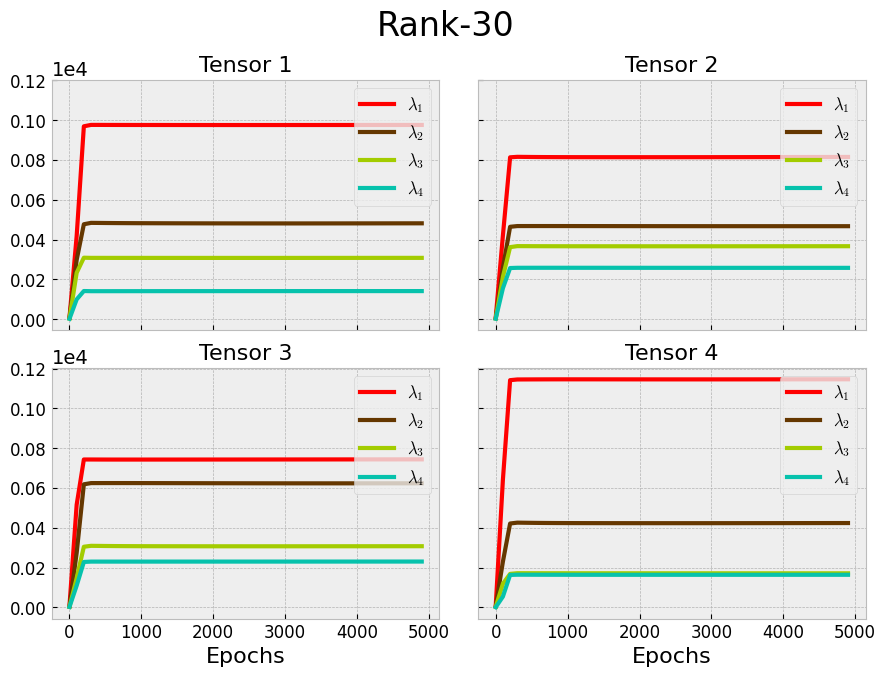

In [25]:
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10.5,7)

for approx_rank in APPROX_RANK:
    S = env_spectrum[approx_rank]
    data = jnp.array(list(S.values())).transpose(1,2,0)
    plot_entanglement_env_spectrum(data, 
                                   title=f'Rank-{approx_rank}',
                                   fig_file=os.path.join(fig_dir, f'{experiment}-entanglement-entropy-environment-approx-rank-{approx_rank}.png'))

# Entanglement Entropy for Bipartitions

In [26]:
def plot_entanglement_entropy(data, title, fig_file=None):

    t = len(data)
    rows = t//3
    cols = 3
    
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=False)
    fig.suptitle(title, fontsize=24)
    plt.subplots_adjust(hspace = 0.15, wspace=0.1)

    for i, (rank, vals) in enumerate(data.items()):
        pid = (i//cols, i%cols) # plot id
        axs[pid].plot(vals[:,0], linewidth=3, label='1-2 bond')          
        axs[pid].plot(vals[:,1], linewidth=3, label='2-3 bond')        
        axs[pid].plot(vals[:,2], linewidth=3, label='3-4 bond')
        axs[pid].set_title(f'Rank {rank}', fontsize=16)
        axs[pid].grid(True)
        axs[pid].legend(loc='lower left', fontsize=12)
        axs[pid].tick_params(axis='both', which='major', labelsize=12)
        axs[pid].tick_params(axis='both', which='minor', labelsize=10)
        axs[pid].ticklabel_format(axis='y', style='sci', scilimits=(4,4))

    for ax in axs.flat:
        ax.set_xlabel(xlabel='Epochs', fontsize=16)
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].label1.set_visible(False)

    for ax in axs.flat:
        ax.label_outer()
    
    xticks_values = [int(l*SAVE_AFTER_EPOCHS) for l in plt.gca().get_xticks()]
    plt.gca().set_xticklabels(xticks_values)

    plt.subplots_adjust(top=0.92)

    if fig_file:
        plt.savefig(fig_file)

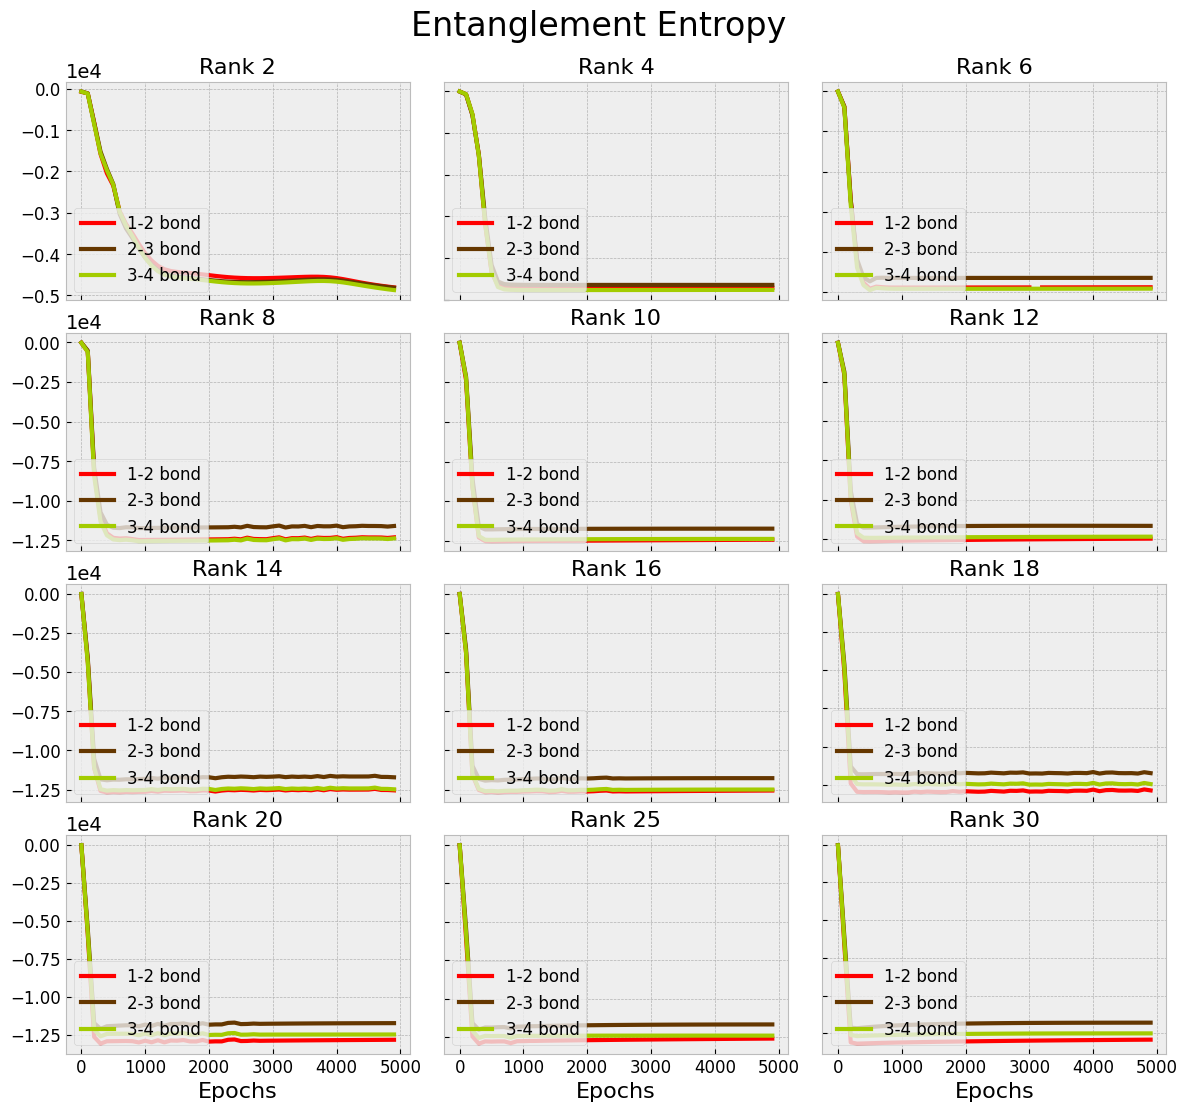

In [27]:
plt.rcParams["figure.figsize"] = (14.2,12)

ent_entropy_data = {k: jnp.array([v for v in vs.values()]) 
                    for k, vs in ent_entropy.items()}
plot_entanglement_entropy(
    ent_entropy_data, 
    title='Entanglement Entropy',
    fig_file=os.path.join(fig_dir, f'{experiment}-entanglement-entropy-all-ranks.png')
    )

# Comparative analysis between experiments

In [28]:
experiment_dirs = [f'{experiment_date}-noise-{noise}-{WEIGHT_INIT}' for noise in PERCENT_NOISE]

In [29]:
results = {}

for edir in experiment_dirs:
    sigma = re.search(f'^([\d-]+noise-)(.*)(-{WEIGHT_INIT})$', edir).group(2)
    results_ = []
    for approx_rank in APPROX_RANK:       
        file_path = os.path.join(parent_dir, edir, 'results', f'approx_rank_{approx_rank}', 'loss.pkl')
        with open(file_path, 'rb') as f:
            res = pickle.load(f)['test']
        data = {k:jnp.mean(jnp.asarray(vs[-100:])) for k,vs in res.items()}
        results_.append(data)
    results[sigma] = reduce(merge, results_)

In [30]:
def plot_approx_rank_curve(results, title, fig_file=None):
    """Plot learning curve for all set of experiments with different noise level."""
    for sigma, data in results.items():
        x, y = zip(*data.items())
        plt.plot(x, y, label=r'$\epsilon={}$'.format(sigma), linewidth=3)
        plt.yscale('log')
        plt.grid(True)
        plt.xlabel('Approximation Rank', fontsize=20)
        plt.ylabel('Loss', fontsize=20)
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.legend(loc='lower right', fontsize=16)
        plt.title(title, fontsize=24)
        
    if fig_file:
        plt.savefig(fig_file)

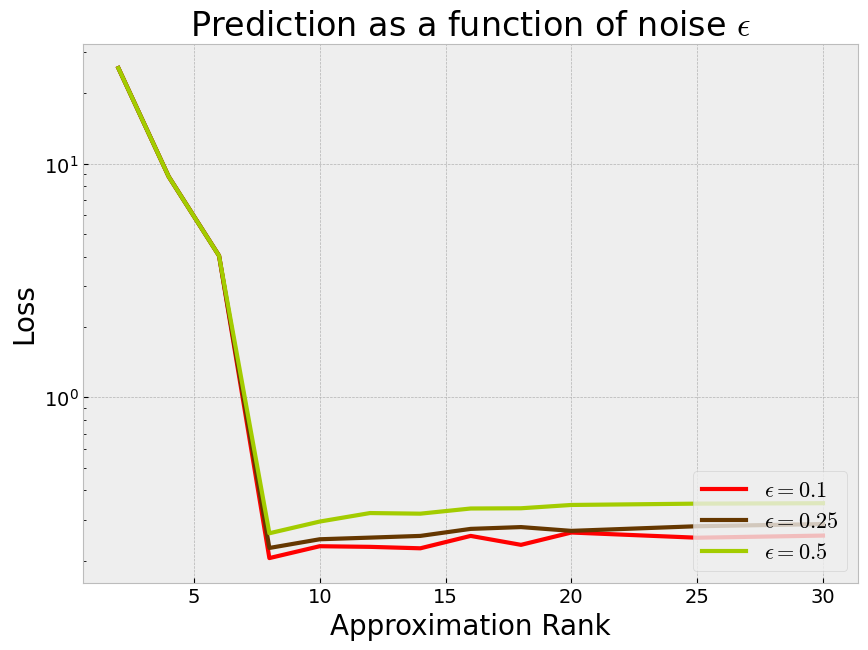

In [31]:
plt.rcParams["figure.figsize"] = (10,7)

plot_approx_rank_curve(
    results, title='Prediction as a function of noise $\epsilon$',
    fig_file=os.path.join(fig_dir, f'{experiment}-logloss-vs-rank-prediction-vs-noise.png')
    )